In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [3]:
# Create images with random rectangles and bounding boxes. 
num_imgs = 50000

img_size = 8
min_object_size = 1
max_object_size = 4
num_objects = 1

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))  # set background to 0

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x+w, y:y+h] = 1.  # set rectangle to 1
        bboxes[i_img, i_object] = [x, y, w, h]
        
imgs.shape, bboxes.shape

((50000, 8, 8), (50000, 1, 4))

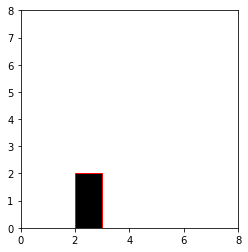

In [4]:
i = 0
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

In [5]:
# Reshape and normalize the image data to mean 0 and std 1. 
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

((50000, 64), -7.046807581900793e-17, 1.0)

In [6]:
# Normalize x, y, w, h by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IOU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, np.mean(y), np.std(y)

((50000, 4), 0.280745625, 0.17494714464191571)

In [7]:
# Split training and test.
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

In [8]:
# Build the model.
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
model = Sequential([
        Dense(200, input_dim=X.shape[-1]), 
        Activation('relu'), 
        Dropout(0.2), 
        Dense(y.shape[-1])
    ])
model.compile('adadelta', 'mse')

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
# Train.
model.fit(train_X, train_y, epochs=30, verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
 - 1s - loss: 0.0251
Epoch 2/30
 - 1s - loss: 0.0017
Epoch 3/30
 - 1s - loss: 0.0013
Epoch 4/30
 - 1s - loss: 0.0011
Epoch 5/30
 - 1s - loss: 0.0010
Epoch 6/30
 - 1s - loss: 9.4678e-04
Epoch 7/30
 - 1s - loss: 8.9581e-04
Epoch 8/30
 - 1s - loss: 8.7129e-04
Epoch 9/30
 - 1s - loss: 8.2645e-04
Epoch 10/30
 - 1s - loss: 8.1324e-04
Epoch 11/30
 - 1s - loss: 7.9568e-04
Epoch 12/30
 - 1s - loss: 7.7448e-04
Epoch 13/30
 - 1s - loss: 7.5819e-04
Epoch 14/30
 - 1s - loss: 7.4823e-04
Epoch 15/30
 - 1s - loss: 7.4009e-04
Epoch 16/30
 - 1s - loss: 7.2417e-04
Epoch 17/30
 - 1s - loss: 7.1609e-04
Epoch 18/30
 - 1s - loss: 7.0825e-04
Epoch 19/30
 - 1s - loss: 6.9885e-04
Epoch 20/30
 - 1s - loss: 6.9469e-04
Epoch 21/30
 - 1s - loss: 6.9013e-04
Epoch 22/30
 - 1s - loss: 6.8220e-04
Epoch 23/30
 - 1s - loss: 6.7367e-04
Epoch 24/30
 - 1s - loss: 6.6305e-04
Epoch 25/30
 - 1s - loss: 6.6164e-04
Epoch 26/30
 - 1s - loss: 6.6552e-04
Epoch 27/30
 - 1s -

In [10]:
# Predict bounding boxes on the test images.
pred_y = model.predict(test_X)
pred_bboxes = pred_y * img_size
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(10000, 1, 4)

In [14]:

def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

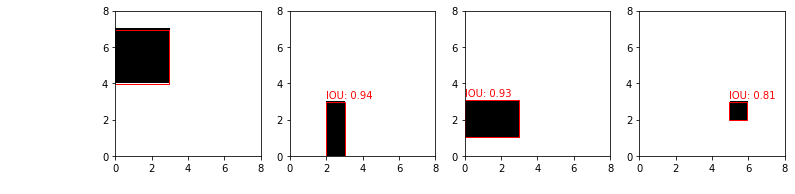

In [15]:

# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')
        
# plt.savefig('plots/bw-single-rectangle_prediction.png', dpi=300)

In [16]:

# Calculate the mean IOU (overlap) between the predicted and expected bounding boxes on the test dataset. 
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU

0.8571275475055667

# Emma testar

# Imports

In [17]:
import tarfile
import os
import scipy.io
import skimage.io
import skimage.color
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from sklearn.naive_bayes import GaussianNB
from mpl_toolkits.mplot3d import Axes3D
from skimage.color import rgb2gray
import skimage.morphology as mp

In [18]:
data_base_path = ('data')
data_folder = 'project-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [19]:
def load_images():

    train_dir = os.path.join(data_base_path, data_folder +'/images/train/')
    dir_train_list = sorted(os.listdir(train_dir))
    train = [skimage.io.imread(os.path.join(train_dir, file)) for file in dir_train_list]

    
    test_dir = os.path.join(data_base_path, data_folder +'/images/test/')
    dir_test_list = sorted(os.listdir(test_dir))
    test = [skimage.io.imread(os.path.join(test_dir, file)) for file in dir_test_list]
    
    val_dir = os.path.join(data_base_path, data_folder +'/images/validation/')
    dir_val_list = sorted(os.listdir(val_dir))
    validation = [skimage.io.imread(os.path.join(val_dir, file)) for file in dir_val_list]
    
    return train, test, validation

In [20]:
def parse_xml_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [21]:
train, test, validation = load_images()

In [22]:
def load_annotations():
    dir_train = os.path.join(data_base_path, data_folder + '/annotations/train/')
    dir_train_list = sorted(os.listdir(dir_train))
    train_files = [f for f in dir_train_list if os.path.isfile(os.path.join(dir_train, f))]
    train_annotations = [parse_xml_file(os.path.join(dir_train, file)) for file in train_files]
    
    
    dir_test = os.path.join(data_base_path, data_folder + '/annotations/test/')
    dir_test_list = sorted(os.listdir(dir_test))
    test_files = [f for f in dir_test_list if os.path.isfile(os.path.join(dir_test, f))]
    test_annotations = [parse_xml_file(os.path.join(dir_test, file)) for file in test_files]
    
    dir_val = os.path.join(data_base_path, data_folder + '/annotations/validation/')
    dir_val_list = sorted(os.listdir(dir_val))
    val_files = [f for f in dir_val_list if os.path.isfile(os.path.join(dir_val, f))]
    validation_annotations = [parse_xml_file(os.path.join(dir_val, file)) for file in val_files]
    
    return train_annotations, test_annotations, validation_annotations

In [27]:
def remove_yellow(img):
    out = img.copy()
    
    red = out[:,:,0]
    green = out[:,:,1]
    blue = out[:,:,2]
    
    is_yellow =  (red > 100) & (red < 250) & (green > 100) & (green < 250) & (blue > 0) & (blue < 200)
    
    red[is_yellow] = 255
    green[is_yellow] = 255
    blue[is_yellow] = 255
    
    out[:,:,0] = red
    out[:,:,1] = green
    out[:,:,2] = blue
    
    return out

In [28]:
#Thresholding the image between two thresholds
def threshold(image, th1, th2):
    th_img = image.copy()
    th_img[th_img<th1] = 0
    th_img[th_img>th2] = 0
    th_img[(th_img>=th1) & (th_img<=th2)] = 255
    return th_img

In [29]:
def preprocess_image(img):
    img = remove_yellow(img)
    img_g = rgb2gray(img)
    img_th = mp.erosion(mp.erosion(threshold(skimage.img_as_ubyte(img_g), 1, 100)))
    return img_th
    

In [30]:
def preprocess_images(train, test, validation):
    for i in range(len(train)):
        train[i] = preprocess_image(train[i])
        
    for i in range(len(test)):
        test[i] = preprocess_image(test[i])
        
    for i in range(len(validation)):
        validation[i] = preprocess_image(validation[i])
         
    return train, test, validation


In [31]:
train_pro, test_pro, validation_pro = preprocess_images(train, test, validation[0:2])

/anaconda3/envs/ada/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [23]:
train_annotations, test_annotations, validation_annotations = load_annotations()

In [24]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [26]:
train_annotations[0]

[{'name': 'Varroa', 'bbox': [1490, 815, 34, 34]}]

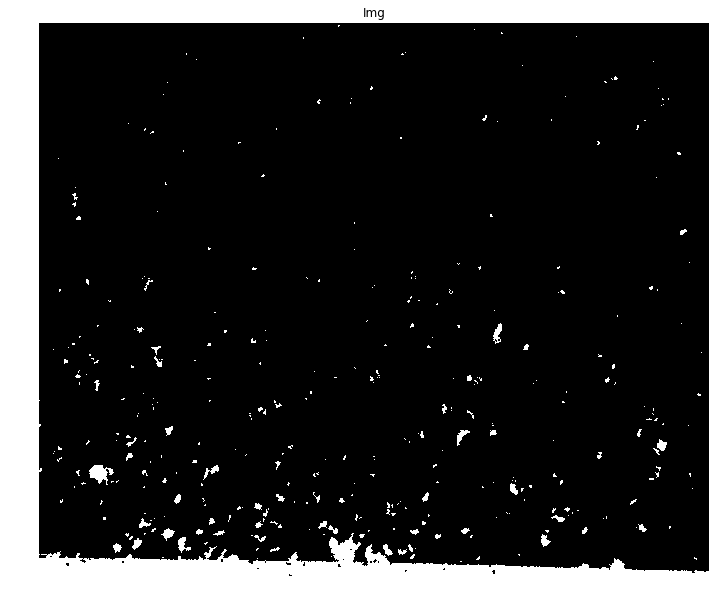

In [37]:
# Plot images
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
# Iterate over annotations
for anno in train_annotations[2]:
    rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
            linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

ax.imshow(train[2], cmap='gray')
ax.axis('off')
ax.set_title('Img')
plt.show()